# Storm tides since 1900 Delfzijl, NL

This notebook analyses the storm tides registered since 1900 at Delfzijl, the Netherlands. As large parts of the Netherlands reside below sea level and so protected against the sea by dunes and dikes, it is interesting to analyse the data, grab for possible trends in more than a century and possibly predict future storm tides. <br>
Marker in Delfzijl's main watergate to commemorate the 1962 storm surge:![](data/marker1962surgeDZ.jpg)

## Collecting data
Delfzijl is one of the 8 Dutch coastal stations continuously measuring the sea water level. Delfzijl, a port in the furthest north-east of the Netherlands, is chosen because of its location on the estuary of the river Ems (water impoundment), the availability of long-term tidal data and, due to gas exploration, a comparatively fast sinking soil. So far the Delfzijl station 2 times measured tides above the national alarm code red, both in the 21st century.<br><br>
Most of the data is available in public sources but not in an easy to use format. So I decided to make a simple dataset using data from mainly Rijkswaterstaat (the Dutch Directorate-General for Public Works and Water Management). Each row in this CSV file has the attributes:
1. date of storm surge
2. max registered water level above NAP (Amsterdam Ordnance Datum)
3. assigned label alarm level:  
3.1 Yellow: >= 3.00 m above sea level  
3.2 Orange: >= 3.80 m above sea level  
3.3 Red: >= 4.75 m above sea level  
4. remark, e.g. name of storm

The publicly available data I used can be found in Rijkswaterstaat [storm surge reports](https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen) as from 1948. Delfzijl storm tides starting from 1900 are given in some of these reports.<br>
Note that the dataset contains yellow warning levels (>= 3.00 m) from the 1950s while before only storm tides above ***border level*** 3.34 m were reported.

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
import urllib.request
import pickle
import requests
import datetime

## Read and clean data 
Remarks are not read. A few historical sea level records before 1900 are left out.

In [2]:
def columnsToDisplay():
    return ['date', 'm_above_NAP', 'warning_code']

In [3]:
def columnsRenameDict():
    return {'m_above_NAP':'meters_above_sealevel', 'warning_code':'alarm_level' }

In [4]:
def preProcessing(df):
    df.date=(pd.to_datetime(df.date, dayfirst=True)) 

In [5]:
df = pd.read_csv('data/storm-tides-Delfzijl-NL.csv', usecols=columnsToDisplay())
df.rename(columns=columnsRenameDict(), inplace=True)
preProcessing(df)
df.tail(20)
dfNew=df[df.date>='01-01-1900'].copy()

Some basic stuff on the dataset

In [6]:
dfNew.dtypes

date                     datetime64[ns]
meters_above_sealevel           float64
alarm_level                      object
dtype: object

In [7]:
print(dfNew.shape)
print('Average height (m): ', round(dfNew.meters_above_sealevel.mean(),2))

(95, 3)
Average height (m):  3.63


In [8]:
dfFourMeters=dfNew[dfNew.meters_above_sealevel >= 4.00]
dfFourMeters

,date,meters_above_sealevel,alarm_level
8,2014-10-22,4.02,O
9,2013-12-06,4.82,R
10,2013-12-06,4.25,O
13,2007-11-09,4.21,O
16,2006-11-01,4.83,R
25,1995-01-10,4.04,O
30,1994-01-28,4.25,O
52,1976-01-21,4.08,O
53,1976-01-04,4.35,O
54,1976-01-03,4.06,O


In [9]:
print(dfFourMeters.alarm_level.unique())
thisCentury=dfFourMeters[dfFourMeters.date >= '01-01-2000']
print('Since 1900', thisCentury.date.count(), 'from', dfFourMeters.date.count(), 'tides above 4.00 m in 21st century')


['O' 'R']
Since 1900 5 from 16 tides above 4.00 m in 21st century


## Exploratory data analysis
First show the storm surge frequency over the years. Remarks to the histogram:
* As high tide occurs twice a day, they are included in the count.
* As from the 1950's tides between 3.00 and 3.34 are included.

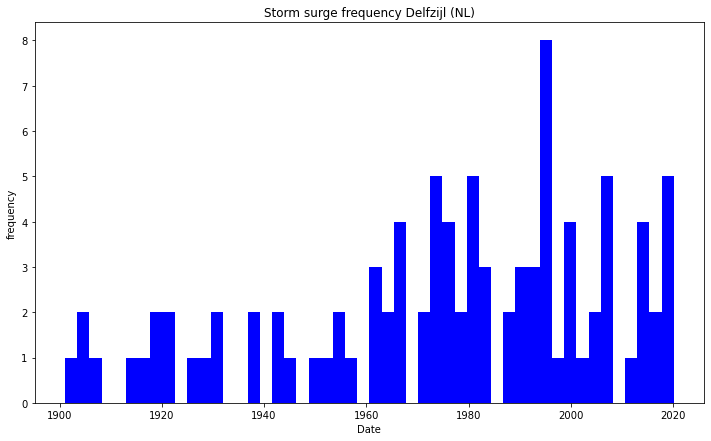

In [10]:
plt.figure(figsize=(12,7))
plt.hist(dfNew.date, bins=50, color='b')
plt.title('Storm surge frequency Delfzijl (NL)')
plt.xlabel('Date')
plt.ylabel('frequency')
plt.show()

Then find out the which heights occur most. 

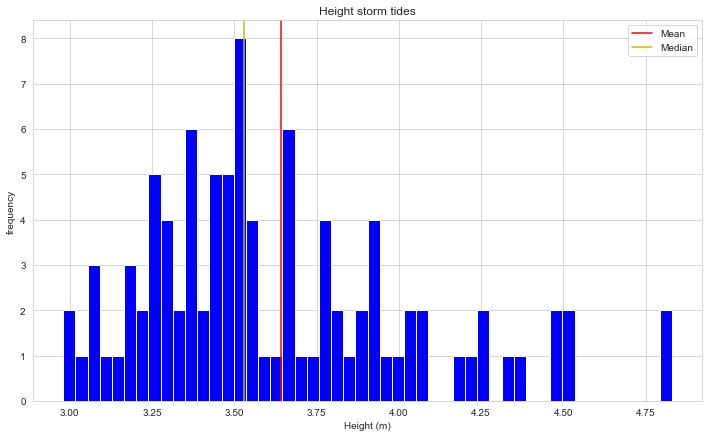

In [11]:
plt.figure(figsize=(12,7))
meanHeight=df.meters_above_sealevel.mean()
medianHeight=df.meters_above_sealevel.median()
with sns.axes_style("whitegrid"):
    plt.hist(dfNew.meters_above_sealevel, bins=50, color='b')
    plt.axvline(meanHeight, 0, 1, color='r', label='Mean')
    plt.axvline(medianHeight, 0, 1, color='y', label='Median')
    plt.title('Height storm tides')
    plt.xlabel('Height (m)')
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

Can we discover a storm surge season in the Delfzijl dataset? Indeed, the barplot places all storm surges between September and April. So far summer storms have not yet been reported.

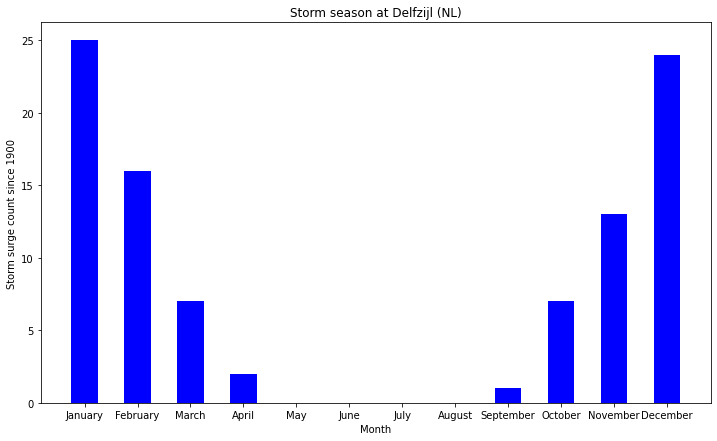

In [12]:
yearDict={'January' : 0, 'February' : 0, 'March' : 0, 'April' : 0, 'May' : 0, 'June' : 0, 'July' : 0, 'August' : 0, 'September' : 0, 'October' : 0, 'November' : 0, 'December' : 0}
season=df.groupby(dfNew['date'].dt.strftime('%B'))['meters_above_sealevel'].count()
for key, value in season.items():
    for yearKey in yearDict.keys():
        if yearKey == key:
            yearDict[key] = value
lists = yearDict.items() # return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(12,7))
plt.title('Storm season at Delfzijl (NL)')
plt.xlabel('Month')
plt.ylabel('Storm surge count since 1900')
plt.bar(x, y, width=.5, color='b')
plt.show()

Categorized storm tides since 1900. The majority of the orange labeled tides occur after the 1960s as well as the two red tides (after 2000). More warning level tides (yellow) are reported as well but that's due to the earlier not reported tides between 3.00 and 3.34.<br> The Delfzijl station measured the elsewhere devastating storm surge of 01-02-1953 with a storm tide of 3.27 which is ***below*** the 3.34 border level then in force.

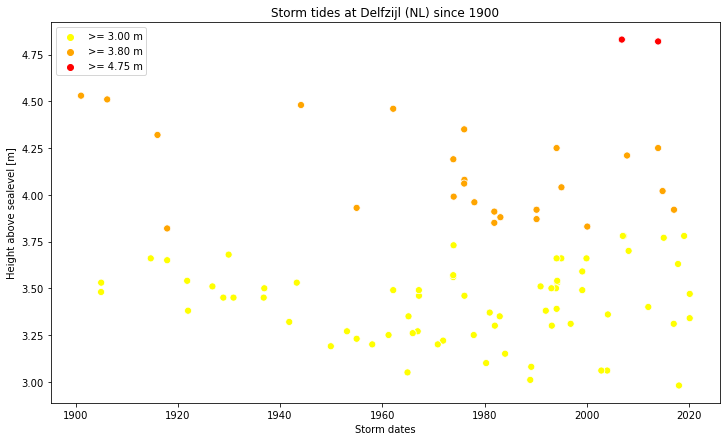

In [13]:
plt.figure(figsize=(12,7))
my_colours = ['yellow', 'orange', 'red']# Set your custom color palette
sns.set_palette(sns.color_palette(my_colours))
classes = dfNew.alarm_level.values
labels=[]
for c in classes:
    if c == 'Y':
        labels.append('>= 3.00 m')
    elif c == 'O':
        labels.append('>= 3.80 m')
    else:
        labels.append('>= 4.75 m')
sns.scatterplot(x=dfNew.date, y=dfNew.meters_above_sealevel, hue=labels, s=50)
plt.title('Storm tides at Delfzijl (NL) since 1900')
plt.ylabel('Height above sealevel [m]')
plt.xlabel('Storm dates')
plt.show()

Some initial linear regression (below) to find a trend in Delfzijl storm tides is for reasons below hard to maintain:
* the scattered points ignore the ***weight*** that is assigned by the alarm level labels
* the scattering to the right (from the 1950s) is too heavy as tides up to 3.34 m are included
* no storm surge reports before 1948 are found; so might be missing points here

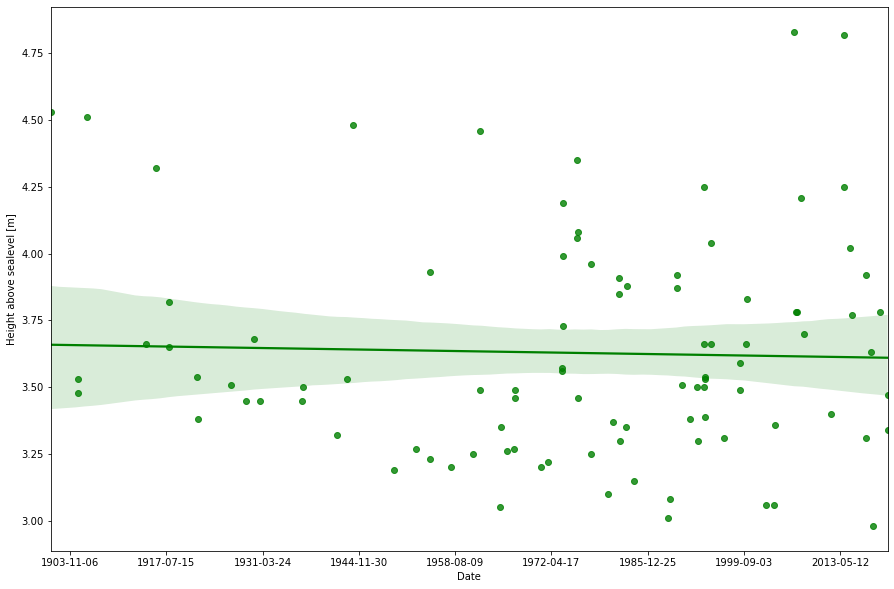

In [14]:
# to fit the linear regression line, date is converted to ordinal equivalent (experienced regplot() to have date problems)
dfNew['date_ordinal']=pd.to_datetime(dfNew['date']).apply(lambda date: date.toordinal())
plt.figure(figsize=(15,10))
ax=sns.regplot(y='meters_above_sealevel', x='date_ordinal', data=dfNew, color='g')
ax.set_xlabel('Date')
ax.set_ylabel('Height above sealevel [m]')
# reset ordinal ticks to common date format
new_labels=[datetime.date.fromordinal(int(ordinal)) for ordinal in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.show()
#dfNew.drop(columns=['date_ordinal'])